In [1]:
import pandas as pd
import requests as re
import matplotlib.pyplot as plt
import numpy as np
import random
import dataframe_image as dfi
from bs4 import BeautifulSoup

In [2]:
captains = ["Lee Mack", "David Mitchell"]

### Create Statements DF

In [3]:
sdf = pd.read_csv('seasons.csv')
#sdf.columns = ["Season", "Episode", "Defender", "Captain", "Opp1", "Opp2", "Opp3", "Verdict1", "Verdict2", "Verdict3"]
sdf["Statement"] = sdf.index
sdf["VerdictMaj"] = sdf[["Verdict1", "Verdict2", "Verdict3"]].sum(axis=1) >= 2
sdf["OppCaptain"] = sdf.Captain.apply(lambda x: captains[0] if captains[0]!=x else captains[1])

In [4]:
opdf = sdf.melt(id_vars=["Statement", "Season", "Episode", "Defender", "Captain", "OppCaptain", "Veracity", "VerdictTeam", "VerdictMaj"], value_vars=["Opp1", "Opp2", "Opp3"], value_name="Opponent").sort_values(by=["Statement", "variable"]).reset_index(drop=True)
verdf = sdf.melt(id_vars=["Statement", "Season", "Episode", "Defender", "Captain", "OppCaptain", "Veracity", "VerdictTeam", "VerdictMaj"], value_vars=["Verdict1", "Verdict2", "Verdict3"], value_name="Verdict").sort_values(by=["Statement", "variable"]).reset_index(drop=True)
opdf["Verdict"] = verdf["Verdict"]

In [5]:
#Scoring each statement
opdf["Off"] = 1
opdf["Off"] = opdf["Off"] * opdf["Verdict"]
opdf["Def"] = 1 - opdf["Off"]

## Create Contestants DF

In [6]:
cdf = pd.DataFrame(opdf.groupby(["Season", "Episode", "OppCaptain"]).Opponent.unique()).reset_index().explode('Opponent').reset_index(drop=True)
cdf.columns = ["Season", "Episode", "Captain", "Player"]
cdf["Title"] = cdf["Season"].map('{:02d}'.format) + "x" + cdf["Episode"].map('{:02d}'.format)
cdf = cdf[["Title", "Season", "Episode", "Player", "Captain"]]

In [7]:
offs = []
defs = []
ostats = []
dstats = []
dtruths = []

for i in range(len(cdf)):
    season = cdf.iloc[i].Season
    episode = cdf.iloc[i].Episode
    opponent = cdf.iloc[i].Player
    ndf = opdf[(opdf.Season == season) & (opdf.Episode == episode) & (opdf.Opponent == opponent)]
    off = round(ndf.Off.mean()*9, 2)
    ostat = len(ndf)

    ndf = opdf[(opdf.Season == season) & (opdf.Episode == episode) & (opdf.Defender == opponent)]
    defn = round(ndf.Def.mean()*9, 2)
    dstat = len(ndf)/3
    dtruth = ndf.Veracity.sum()
    if dstat > 0: dtruth = dtruth/(3*dstat)

    offs.append(off)
    defs.append(defn)
    ostats.append(ostat)
    dstats.append(dstat)
    dtruths.append(dtruth)

In [8]:
cdf["OR"] = offs
cdf["DR"] = defs
cdf["DR"] = cdf["DR"].fillna(0.8*4.5)
cdf["TR"] = cdf["OR"] + cdf["DR"]
cdf["OStatements"] = ostats
cdf["DStatements"] = dstats
cdf["DTruths"] = dtruths

cdf["TMVP"] = False
cdf["Max"] = False
cdf["OPOE"] = False
cdf["DPOE"] = False
cdf["RLOW"] = False
cdf["OPOS"] = False
cdf["DPOS"] = False
cdf["ModOR"] = 1
cdf["ModDR"] = 1
cdf["TeamOR"] = 1
cdf["TeamDR"] = 1
cdf["LieDR"] = (((1-cdf.DTruths) * 0.5) + 0.5) * cdf.DR

In [9]:
#Create modifiers for ORing and DRing based on number of statements
cdf.loc[cdf["OStatements"] < 3, "ModOR"] = 0.75
cdf.loc[cdf["OStatements"] < 2, "ModOR"] = 0.5
cdf["ModOR"] = cdf["ModOR"] * cdf["OR"]

cdf.loc[cdf["DStatements"] < 2, "ModDR"] = 0.8
cdf["ModDR"] = cdf["ModDR"] * cdf["DR"]

### Determine adjusted ratings

In [10]:
oodf = cdf.groupby(["Title", "Captain"]).ModOR.median().unstack(0).transpose().reset_index()
oodf[captains] = (cdf.groupby(["Title", "Captain"]).ModOR.median().unstack(0).transpose().reset_index()[captains] + cdf.groupby(["Title", "Captain"]).ModOR.min().unstack(0).transpose().reset_index()[captains])/2
oodf.columns = ["Title", "MitchellOR", "MackOR"]
cdf = cdf.merge(oodf, left_on="Title", right_on="Title")

oddf = cdf.groupby(["Title", "Captain"]).ModDR.median().unstack(0).transpose().reset_index()
oddf[captains] = (cdf.groupby(["Title", "Captain"]).ModDR.median().unstack(0).transpose().reset_index()[captains] + cdf.groupby(["Title", "Captain"]).ModDR.min().unstack(0).transpose().reset_index()[captains])/2
oddf.columns = ["Title", "MitchellDR", "MackDR"]
cdf = cdf.merge(oddf, left_on="Title", right_on="Title")

In [11]:
cdf.loc[cdf.Captain == "David Mitchell", "TeamOR"] = cdf.loc[cdf.Captain == "David Mitchell", "MitchellOR"]
cdf.loc[cdf.Captain == "Lee Mack", "TeamOR"] = cdf.loc[cdf.Captain == "Lee Mack", "MackOR"]
cdf.loc[cdf.Captain == "David Mitchell", "TeamDR"] = cdf.loc[cdf.Captain == "David Mitchell", "MitchellDR"]
cdf.loc[cdf.Captain == "Lee Mack", "TeamDR"] = cdf.loc[cdf.Captain == "Lee Mack", "MackDR"]
cdf = cdf.drop(columns = ["MitchellOR", "MackOR", "MitchellDR", "MackDR"])

cdf["ROR"] = np.round(cdf["ModOR"] - cdf["TeamOR"], 2)
cdf["RDR"] = np.round(cdf["ModDR"] - cdf["TeamDR"], 2)
cdf["RTR"] = np.round(cdf.ROR + cdf.RDR, 2)

### Determine awards

In [12]:
#Award TMVP, OPOE, DPOE, OPOS, DPOS

cdf.loc[cdf.groupby(["Title", "Captain"]).TR.idxmax(), "TMVP"] = True
cdf.loc[cdf.groupby(["Title"]).TR.idxmax(), "Max"] = True

tcdf = cdf[cdf.groupby(["Title"]).ROR.transform(max) == cdf.ROR]
tcdf = tcdf[tcdf.groupby(["Title"]).OR.transform(max) == tcdf.OR]
cdf.loc[tcdf.groupby(["Title"]).TR.idxmax(), "OPOE"] = True

tcdf = cdf[cdf.groupby(["Title"]).ModDR.transform(max) == cdf.ModDR]
cdf.loc[tcdf.groupby(["Title"]).TR.idxmax(), "DPOE"] = True

cdf.loc[cdf[cdf.OPOE].groupby("Season").ROR.idxmax(), "OPOS"] = True
cdf.loc[cdf[cdf.DPOE].groupby("Season").RDR.idxmax(), "DPOS"] = True

In [13]:
#Award RLOW
url = "https://wilty.fandom.com/wiki/Rob%27s_Individual_Liar_of_the_Week"
html = re.get(url)
soup = BeautifulSoup(html.content, "html.parser")

table = soup.find_all('table')
rlotw = pd.read_html(str(table))[0]
rlotw["Episode"] = rlotw.Episode.apply(lambda x: 'x'.join(['{:02d}'.format(int(y)) for y in x.split("x")]))

In [14]:
cdf = cdf.merge(rlotw, left_on="Title", right_on="Episode", how="left")
cdf.loc[cdf.Player == cdf.RLotW, "RLOW"] = True

In [15]:
#Award EMVP
sdf = pd.read_csv('winners.csv', index_col=0)

In [16]:
cdf = cdf.merge(sdf, how='left', left_on='Title', right_on='Episode')
cdf["EMVP"] = False
cdf.loc[cdf.Winner == "Tied", "EMVP"] = cdf.loc[cdf.Winner == "Tied", "Max"]
cdf.loc[cdf.Winner == cdf.Captain, "EMVP"] = cdf.loc[cdf.Winner == cdf.Captain, "TMVP"]

### Determine advanced statistics

In [17]:
cdf["FUJI9"] = np.real(np.array(cdf.ROR.values, dtype=np.complex128)**(1/3) + np.array(cdf.RDR.values, dtype=np.complex128)**(1/3))
cdf["FUJI9"] = np.round(cdf.FUJI9, 2)
cdf["CUSHN"] = np.round(cdf.ROR + cdf.DR, 2)
cdf["ANMRI"] = np.round(cdf.OR + cdf.LieDR, 2)

In [18]:

cdf = cdf[["Title", "Season", "Episode_x", "Player", "Captain", "OR", "DR", "TR", "ROR", "RDR", "RTR", "TMVP", "EMVP", "OPOE", "DPOE", "RLOW", "OPOS", "DPOS", "FUJI9", "CUSHN", "ANMRI"]]
cdf.columns = ["Title", "Season", "Episode", "Player", "Captain", "OR", "DR", "TR", "ROR", "RDR", "RTR", "TMVP", "EMVP", "OPOE", "DPOE", "RLOW", "OPOS", "DPOS", "FUJI9", "CUSHN", "ANMRI"]

In [19]:
cdf.to_csv('contestants.csv')

## Create Appearances DF

In [20]:
seasons = range(20)
tdf = cdf[cdf.Season.isin(seasons)]

players = list(tdf.Player.unique())
appearances = []
oR = []
adjoR = []
dR = []
adjdR = []
tR = []
adjtR = []
tmvps = []
emvps = []
opoes = []
dpoes = []
rlows = []
oposs = []
dposs = []
fuji9 = []
cushn = []
anmri = []
for player in players:
    ndf = tdf[tdf.Player == player]
    appearances.append(len(ndf))
    oR.append(round(ndf.OR.mean(), 2))
    adjoR.append(round(ndf.ROR.mean(), 2))
    dR.append(round(ndf.DR.mean(), 2))
    adjdR.append(round(ndf.RDR.mean(), 2))
    tR.append(round(ndf.TR.mean(), 2))
    adjtR.append(round(ndf.ROR.mean(), 2) + round(ndf.RDR.mean(), 2))
    tmvps.append(ndf.TMVP.sum())
    emvps.append(ndf.EMVP.sum())
    opoes.append(ndf.OPOE.sum())
    dpoes.append(ndf.DPOE.sum())
    rlows.append(ndf.RLOW.sum())
    oposs.append(ndf.OPOS.sum())
    dposs.append(ndf.DPOS.sum())
    fuji9.append(round(ndf.FUJI9.mean(), 2))
    cushn.append(round(ndf.CUSHN.mean(), 2))
    anmri.append(round(ndf.ANMRI.mean(), 2))

adf = pd.DataFrame({'Player': players, 'Appearances': appearances, 'OR': oR, 'DR': dR, 'TR': tR, 'ROR': adjoR, 'RDR': adjdR, 'RTR': adjtR, 'TMVP': tmvps, 'EMVP': emvps, 'OPOE': opoes, 'DPOE': dpoes, 'RLOW': rlows, 'OPOS': oposs, 'DPOS': dposs, 'FUJI9': fuji9, 'CUSHN': cushn, 'ANMRI': anmri})
adf["Awards"] = adf["TMVP"] + adf["EMVP"] + adf["OPOE"] + adf["DPOE"] + adf["OPOS"] + adf["DPOS"] + adf["RLOW"]
adf = adf.sort_values(by=["Appearances", "TR", "RTR"], ascending=False)
adf.to_csv('players.csv')

In [21]:
adf[:60]

,Player,Appearances,OR,DR,TR,ROR,RDR,RTR,TMVP,EMVP,OPOE,DPOE,RLOW,OPOS,DPOS,FUJI9,CUSHN,ANMRI,Awards
0,David Mitchell,140,5.86,2.89,8.75,0.68,0.59,1.27,47,25,19,19,0,2,0,1.23,3.57,8.42,112
3,Lee Mack,140,5.77,2.59,8.36,0.79,0.38,1.17,43,23,31,14,0,4,0,1.22,3.38,7.87,115
141,Bob Mortimer,11,5.11,3.27,8.39,0.36,1.15,1.51,1,1,0,3,2,0,0,1.54,3.63,7.33,7
140,Richard Osman,10,7.65,3.00,10.65,1.46,0.88,2.34,4,1,3,1,1,1,0,1.65,4.46,10.39,11
50,Jo Brand,9,6.17,5.00,11.17,0.38,2.93,3.31,5,2,2,3,3,0,1,1.35,5.38,10.08,16
90,Rhod Gilbert,9,7.00,4.17,11.17,0.75,1.48,2.23,3,1,2,2,0,1,0,1.28,4.92,9.71,9
23,Claudia Winkleman,7,5.36,6.21,11.57,0.56,3.56,4.12,6,3,1,5,1,0,2,1.71,6.78,9.59,18
15,Jason Manford,7,5.57,1.71,7.29,0.05,0.51,0.56,1,1,0,0,0,0,0,0.79,1.77,6.43,2
28,Gabby Logan,6,5.75,4.20,9.95,0.50,1.66,2.16,3,0,1,0,2,0,0,1.43,4.70,8.83,6
166,Henning Wehn,6,4.00,3.00,7.00,0.00,0.88,0.88,1,1,0,1,1,0,0,0.71,3.00,5.50,4


## Statistical analysis
### Base statistics

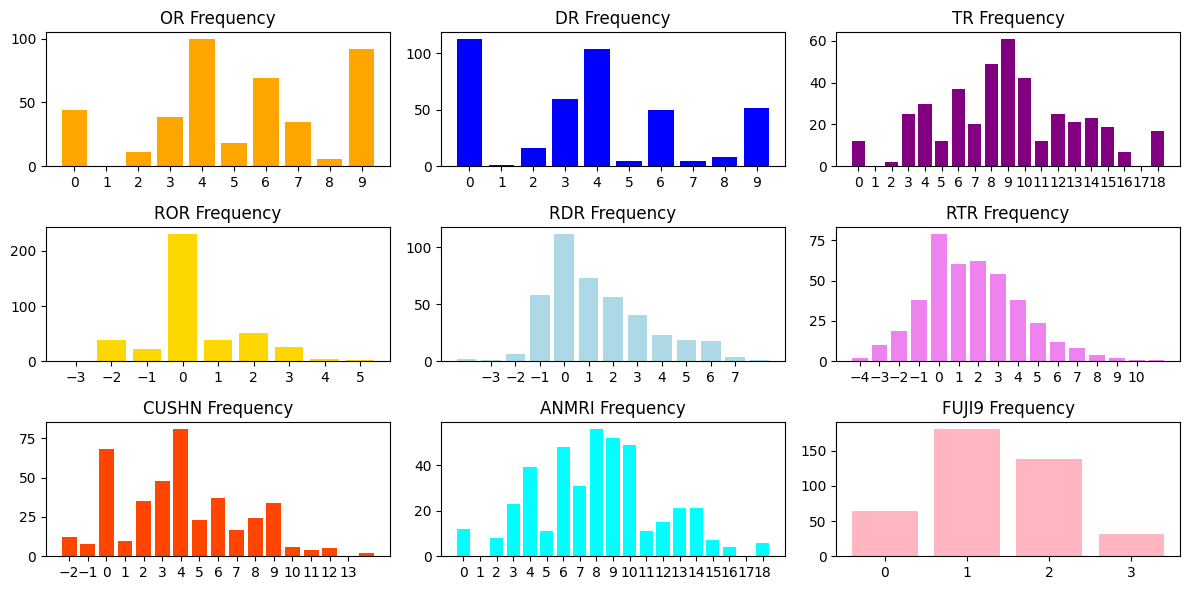

In [22]:
stats = ["OR", "DR", "TR", "ROR", "RDR", "RTR", "CUSHN", "ANMRI", "FUJI9"]
colors = ["orange", "blue", "purple", "gold", "lightblue", "violet", "orangered", "cyan", "lightpink"]
fig, axs = plt.subplots(3, 3, figsize=(12,6))

for i in range(len(axs)):
    for j in range(len(axs[i])):
        ind = i*3 + j
        stat = stats[ind]
        axs[i,j].bar(np.round(adf[stat]).value_counts().index, np.round(adf[stat]).value_counts().values, color=colors[ind])
        axs[i,j].set_xticks(range(int(min(adf[stat])), int(max(adf[stat])+1)))
        axs[i,j].set_title(f"{stat} Frequency")

plt.tight_layout()
plt.show()

### Ratings over time

(0.0, 18.0)

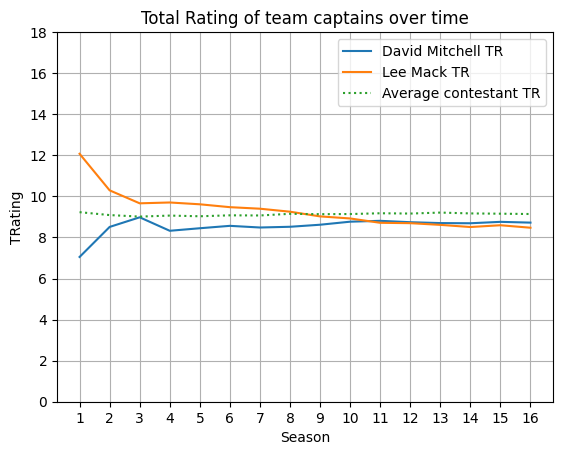

In [23]:
#TRatings over time
t = cdf[cdf.Player.isin(captains)].groupby(["Player", "Season"]).TR.mean().unstack(0)
dt = t["David Mitchell"].expanding().mean()
lt = t["Lee Mack"].expanding().mean()
at = cdf[~cdf.Player.isin(captains)].groupby(["Season"]).TR.mean().expanding().mean()

plt.plot(dt, label="David Mitchell TR")
plt.plot(lt, label="Lee Mack TR")
plt.plot(at, label="Average contestant TR", linestyle="dotted")

plt.xticks(range(1, len(t)+1))
plt.title("Total Rating of team captains over time")
plt.xlabel("Season")
plt.ylabel("TRating")
plt.grid()
plt.legend()
plt.ylim(0, 18)

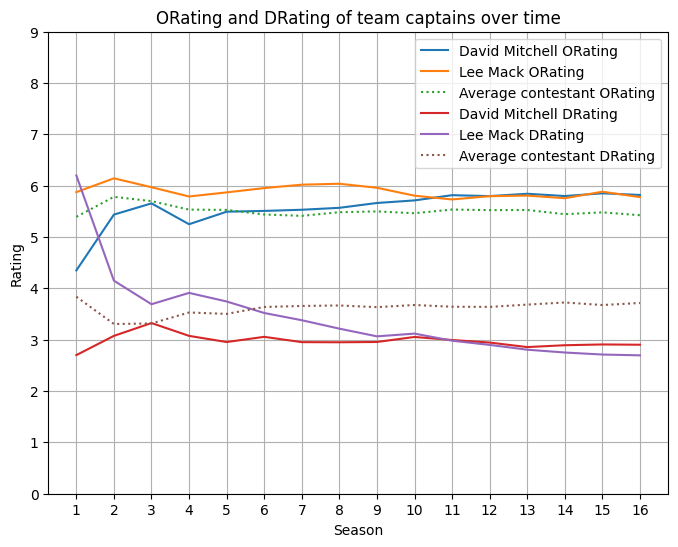

In [24]:
#ORatings and DRatings over time
o = cdf[cdf.Player.isin(captains)].groupby(["Player", "Season"]).OR.mean().unstack(0)
do = o["David Mitchell"].expanding().mean()
lo = o["Lee Mack"].expanding().mean()
ao = cdf[~cdf.Player.isin(captains)].groupby(["Season"]).OR.mean().expanding().mean()

d = cdf[cdf.Player.isin(captains)].groupby(["Player", "Season"]).DR.mean().unstack(0)
dd = d["David Mitchell"].expanding().mean()
ld = d["Lee Mack"].expanding().mean()
ad = cdf[~cdf.Player.isin(captains)].groupby(["Season"]).DR.mean().expanding().mean()

#plt.plot(dt, label="MitchellTR")
#plt.plot(lt, label="MackTR")

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plt.plot(do, label="David Mitchell ORating")
plt.plot(lo, label="Lee Mack ORating")
plt.plot(ao, label="Average contestant ORating", linestyle="dotted")

plt.plot(dd, label="David Mitchell DRating")
plt.plot(ld, label="Lee Mack DRating")
plt.plot(ad, label="Average contestant DRating", linestyle="dotted")

plt.xticks(range(1, len(o)+1))
plt.title("ORating and DRating of team captains over time")
plt.xlabel("Season")
plt.ylabel("Rating")
plt.grid()
plt.legend()
plt.ylim(0, 9)
plt.show()

### MVP races

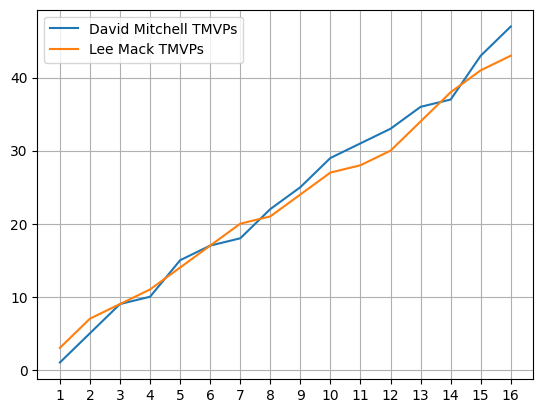

In [25]:
#TMVP race
em = cdf[cdf.Player.isin(captains)].groupby(["Player", "Season"]).TMVP.sum().unstack(0)
plt.plot(em["David Mitchell"].cumsum(), label="David Mitchell TMVPs")
plt.plot(em["Lee Mack"].cumsum(), label="Lee Mack TMVPs")
mx = max(em["David Mitchell"].cumsum().max(), em["Lee Mack"].cumsum().max())
plt.legend()
plt.grid()
plt.xticks(range(1, len(em)+1))
#plt.yticks(range(mx))
plt.show()

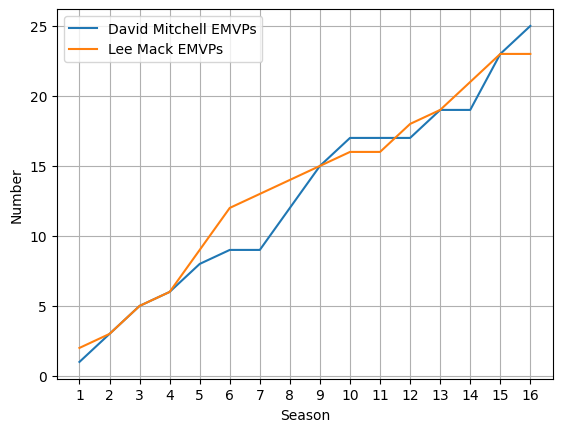

In [26]:
#EMVP race
em = cdf[cdf.Player.isin(captains)].groupby(["Player", "Season"]).EMVP.sum().unstack(0)
plt.plot(em["David Mitchell"].cumsum(), label="David Mitchell EMVPs")
plt.plot(em["Lee Mack"].cumsum(), label="Lee Mack EMVPs")
mx = max(em["David Mitchell"].cumsum().max(), em["Lee Mack"].cumsum().max())
plt.legend()
plt.grid()
plt.xticks(range(1, len(em)+1))
#plt.yticks(range(mx))
plt.xlabel("Season")
plt.ylabel("Number")
plt.show()

### Advanced statistics

In [27]:
color_dict = pd.DataFrame(adf.Player)
r = lambda: random.randint(128,255)
def hxc():
    return '#%02X%02X%02X' % (r(),r(),r())

color_dict["Colour"] = [hxc() for x in color_dict.Player]

In [28]:
def style_cells(val):
    if val in list(color_dict.Player): 
        strn = f'background-color: {color_dict[color_dict.Player == val].Colour.iloc[0]}'
    else:
        strn = f'background-color: white'
    return strn

In [29]:
apps = 2
stats = ["TR", "RTR", "FUJI9", "CUSHN", "ANMRI"]
tops = pd.DataFrame()
tops["Rank"] = range(1, 11)
for stat in stats:
    tops[f"{stat} Leader"] = adf[adf.Appearances > apps].sort_values(by=stat, ascending=False)[:10].Player.values
    tops[f"{stat}"] = adf[adf.Appearances > apps].sort_values(by=stat, ascending=False)[:10][stat].values
styled_tops = tops.style.applymap(style_cells)
styled_tops.format(dict(zip(stats, ["{:.2f}"]*len(stats))))
styled_tops


,Rank,TR Leader,TR,RTR Leader,RTR,FUJI9 Leader,FUJI9,CUSHN Leader,CUSHN,ANMRI Leader,ANMRI
0,1,James Acaster,14.00,Josh Widdicombe,5.86,Miranda Hart,2.25,Miranda Hart,7.99,Miranda Hart,12.75
1,2,Miranda Hart,13.65,Miranda Hart,4.94,Josh Widdicombe,2.24,Josh Widdicombe,7.92,Stephen Mangan,12.12
2,3,Alex Jones,13.12,Alex Jones,4.72,Alex Jones,2.06,Alex Jones,7.78,Joe Lycett,11.00
3,4,Stephen Mangan,12.72,Chris McCausland,4.29,Hugh Dennis,1.86,Chris McCausland,7.03,James Acaster,10.50
4,5,Chris McCausland,12.38,Claudia Winkleman,4.12,Stephen Mangan,1.86,James Acaster,7.00,Richard Osman,10.39
5,6,Josh Widdicombe,12.00,Greg Davies,3.94,Chris McCausland,1.84,Claudia Winkleman,6.78,Jo Brand,10.08
6,7,Claudia Winkleman,11.57,Sara Pascoe,3.64,Jon Richardson,1.84,Sara Pascoe,6.38,Josh Widdicombe,10.03
7,8,Jo Brand,11.17,Jo Brand,3.31,Jimmy Carr,1.75,Stephen Mangan,5.88,Hugh Dennis,10.00
8,9,Rhod Gilbert,11.17,James Acaster,3.28,Mel Giedroyc,1.72,Hugh Dennis,5.63,Rhod Gilbert,9.71
9,10,Hugh Dennis,11.00,Hugh Dennis,3.07,Greg Davies,1.72,Jo Brand,5.38,Alex Jones,9.65


In [30]:
apps = 1
stats = ["TR", "RTR", "FUJI9", "CUSHN", "ANMRI"]
tops = pd.DataFrame()
tops["Rank"] = range(1, 11)
for stat in stats:
    tops[f"{stat} Leader"] = adf[adf.Appearances > apps].sort_values(by=stat, ascending=False)[:10].Player.values
    tops[f"{stat}"] = adf[adf.Appearances > apps].sort_values(by=stat, ascending=False)[:10][stat].values
styled_tops = tops.style.applymap(style_cells)
styled_tops.format(dict(zip(stats, ["{:.2f}"]*len(stats))))
styled_tops

,Rank,TR Leader,TR,RTR Leader,RTR,FUJI9 Leader,FUJI9,CUSHN Leader,CUSHN,ANMRI Leader,ANMRI
0,1,Ruth Jones,15.30,Josh Widdicombe,5.86,Victoria Coren,2.54,Victoria Coren,10.24,Ruth Jones,15.30
1,2,Victoria Coren,15.30,Miranda Hart,4.94,Ruth Jones,2.49,Asim Chaudhry,9.28,Guz Khan,13.12
2,3,James Acaster,14.00,Victoria Coren,4.92,Katherine Parkinson,2.42,Fay Ripley,8.62,Victoria Coren,13.05
3,4,Guz Khan,13.88,Alex Jones,4.72,Miranda Hart,2.25,Ruth Jones,8.55,Miranda Hart,12.75
4,5,Miranda Hart,13.65,Fay Ripley,4.60,Josh Widdicombe,2.24,Miranda Hart,7.99,Stephen Mangan,12.12
5,6,Fay Ripley,13.50,Asim Chaudhry,4.58,Fay Ripley,2.14,Josh Widdicombe,7.92,Joe Lycett,11.00
6,7,Alex Jones,13.12,Chris McCausland,4.29,David Baddiel,2.08,Roisin Conaty,7.80,Alice Levine,10.80
7,8,Asim Chaudhry,12.75,Claudia Winkleman,4.12,Alex Jones,2.06,Alex Jones,7.78,Tom Allen,10.50
8,9,Stephen Mangan,12.72,Ruth Jones,4.05,Asim Chaudhry,2.06,Alice Levine,7.33,James Acaster,10.50
9,10,Chris McCausland,12.38,Lou Sanders,4.00,Hugh Dennis,1.86,Chris McCausland,7.03,Richard Osman,10.39


### Insights

In [31]:
#Mitchell and Mack ORating when overruling their team
opdf[opdf.VerdictTeam != opdf.VerdictMaj].groupby(["OppCaptain"]).Off.mean() * 9

OppCaptain
David Mitchell    4.285714
Lee Mack          4.636364
Name: Off, dtype: float64

In [32]:
#The Bob Mortimer effect
mvm = opdf[(opdf.Defender == "Bob Mortimer") & (opdf.Opponent == "David Mitchell")].Off.mean() * 9
cvm = opdf[(opdf.Opponent == "David Mitchell")].Off.mean() * 9
mvc = opdf[(opdf.Defender == "Bob Mortimer")].Off.mean() * 9

print(f"Average contestant ORating vs Bob Mortimer: {np.round(mvc, 2)}")
print(f"David Mitchell ORating vs Bob Mortimer: {np.round(mvm, 2)}")
print(f"David Mitchell ORating vs average contestant: {np.round(cvm, 2)}")

Average contestant ORating vs Bob Mortimer: 5.37
David Mitchell ORating vs Bob Mortimer: 5.21
David Mitchell ORating vs average contestant: 5.84


In [33]:
mitch = opdf[opdf.Opponent == "David Mitchell"]
mitchvals = mitch.Defender.value_counts()
pd.DataFrame(np.round(mitch[mitch.Defender.isin(mitchvals[mitchvals >= 5].index)].groupby("Defender").Def.mean() * 9, 2)).merge(adf, left_on="Defender", right_on="Player", how="left")[["Player", "Def", "DR"]]

,Player,Def,DR
0,Bob Mortimer,3.79,3.27
1,Henning Wehn,1.50,3.00
2,Jo Brand,5.00,5.00
3,Lee Mack,1.90,2.59
4,Rhod Gilbert,3.60,4.17
5,Sara Pascoe,5.40,6.00


In [34]:
mack = opdf[opdf.Opponent == "Lee Mack"]
mackvals = mack.Defender.value_counts()
pd.DataFrame(np.round(mack[mack.Defender.isin(mackvals[mackvals >= 5].index)].groupby("Defender").Def.mean() * 9, 2)).merge(adf, left_on="Defender", right_on="Player", how="left")[["Player", "Def", "DR"]]

,Player,Def,DR
0,Claudia Winkleman,5.62,6.21
1,David Mitchell,1.92,2.89
2,Greg Davies,5.40,4.12
3,Jason Manford,1.50,1.71
4,Rhod Gilbert,3.00,4.17
5,Richard Osman,2.70,3.00


In [35]:
#Captains against each other
dvl = np.round(opdf[(opdf.Defender == "David Mitchell") & (opdf.Opponent == "Lee Mack")].Def.mean() * 9, 2)
lvd = np.round(opdf[(opdf.Defender == "Lee Mack") & (opdf.Opponent == "David Mitchell")].Def.mean() * 9, 2)

print(f"David Mitchell DRating vs Lee Mack: {dvl}")
print(f"Lee Mack DRating vs David Mitchell: {lvd}")

David Mitchell DRating vs Lee Mack: 1.92
Lee Mack DRating vs David Mitchell: 1.9
